# Bedrock Inline Agent with LangGraph

In this notebook, we demonstrate how to use Bedrock Inline Agents with LangGraph using the BedrockInlineAgentsRunnable. We'll create a mortgage rate assistant that uses two tools: one for retrieving asset values and another for determining mortgage rates.

### Prerequisites:
1. AWS credentials configured
2. langchain, langgraph, and boto3 packages installed
3. langchain-aws package accessible

### Step 1: Define the tools for the agent

In [1]:
from langchain_core.tools import tool

@tool("AssetDetail::getAssetValue")
def get_asset_value(asset_holder_id: str) -> str:
    """
    Get the asset value for an owner id

    Args:
        asset_holder_id: The asset holder id

    Returns:
        The asset value for the given asset holder
    """
    return f"The total asset value for {asset_holder_id} is 100K"

@tool("AssetDetail::getMortgageRate")
def get_mortgage_rate(asset_holder_id: str, asset_value: str) -> str:
    """
    Get the mortgage rate based on asset value

    Args:
        asset_holder_id: The asset holder id
        asset_value: The value of the asset

    Returns:
        The interest rate for the asset holder and asset value
    """
    return f"The mortgage rate for {asset_holder_id} with asset value of {asset_value} is 8.87%"

tools = [get_asset_value, get_mortgage_rate]
tools

[StructuredTool(name='AssetDetail::getAssetValue', description='Get the asset value for an owner id\n\nArgs:\n    asset_holder_id: The asset holder id\n\nReturns:\n    The asset value for the given asset holder', args_schema=<class 'langchain_core.utils.pydantic.AssetDetail::getAssetValue'>, func=<function get_asset_value at 0x111bcf740>),
 StructuredTool(name='AssetDetail::getMortgageRate', description='Get the mortgage rate based on asset value\n\nArgs:\n    asset_holder_id: The asset holder id\n    asset_value: The value of the asset\n\nReturns:\n    The interest rate for the asset holder and asset value', args_schema=<class 'langchain_core.utils.pydantic.AssetDetail::getMortgageRate'>, func=<function get_mortgage_rate at 0x111bcfc40>)]

### Step 2: Create the BedrockInlineAgentsRunnable with configuration

In [2]:
from langchain_aws.agents import BedrockInlineAgentsRunnable

foundation_model = 'anthropic.claude-3-sonnet-20240229-v1:0'
instructions = "You are an agent who helps with getting the mortgage rate based on the current asset valuation"

inline_agent_config = {
    "foundation_model": foundation_model,
    "instruction": instructions,
    "tools": tools,
    "enable_trace": True
}

agent = BedrockInlineAgentsRunnable.create(
    region_name="us-west-2",
    inline_agent_config=inline_agent_config
)

agent

BedrockInlineAgentsRunnable(client=<botocore.client.AgentsforBedrockRuntime object at 0x115465a30>, region_name='us-west-2', inline_agent_config={'foundation_model': 'anthropic.claude-3-sonnet-20240229-v1:0', 'instruction': 'You are an agent who helps with getting the mortgage rate based on the current asset valuation', 'enable_trace': True, 'tools': [StructuredTool(name='AssetDetail::getAssetValue', description='Get the asset value for an owner id\n\nArgs:\n    asset_holder_id: The asset holder id\n\nReturns:\n    The asset value for the given asset holder', args_schema=<class 'langchain_core.utils.pydantic.AssetDetail::getAssetValue'>, func=<function get_asset_value at 0x111bcf740>), StructuredTool(name='AssetDetail::getMortgageRate', description='Get the mortgage rate based on asset value\n\nArgs:\n    asset_holder_id: The asset holder id\n    asset_value: The value of the asset\n\nReturns:\n    The interest rate for the asset holder and asset value', args_schema=<class 'langchain_c

### Step 3: Define the State for your Graph

In [3]:
import operator
from typing import TypedDict, Annotated, Tuple, Union
from langchain_aws.agents import BedrockAgentAction, BedrockAgentFinish

class AgentState(TypedDict):
    """
    Defines the state for the Graph
    """
    input_text: str
    """Input to the agent"""
    output: Union[BedrockAgentAction, BedrockAgentFinish, None]
    """Output from the agent"""
    intermediate_steps: Annotated[list[tuple[BedrockAgentAction, str]], operator.add]
    """Intermediate steps tracked in the state"""

### Step 4: Define the nodes for your LangGraph

In [4]:
from langgraph.prebuilt.tool_executor import ToolExecutor

# The agent node
def run_agent(data: AgentState) -> dict:
    # Add inline_agent_config to the input data
    agent_input = {
        "input_text": data["input_text"],
        "inline_agent_config": inline_agent_config
    }
    
    # Add intermediate steps if they exist
    if data.get("intermediate_steps"):
        agent_input["intermediate_steps"] = data["intermediate_steps"]
    
    agent_outcome = agent.invoke(agent_input)
    return {"output": agent_outcome}

# The tools node
tool_executor = ToolExecutor(tools)

def execute_tools(data: AgentState) -> dict:
    agent_action = data["output"]
    output = tool_executor.invoke(agent_action[0])
    tuple_output = agent_action[0], output
    print(f"Tool execution output: {tuple_output}")
    return {"intermediate_steps": [tuple_output]}

/var/folders/1l/q3xxclj90k9f3qkbnb73rt1h0000gq/T/ipykernel_31988/666337232.py:19: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


### Step 5: Define the conditional function for workflow control

In [5]:
def should_continue(data: AgentState) -> str:
    output_ = data["output"]

    # Continue if BedrockAgentAction
    if isinstance(output_, list) and len(output_) > 0 and isinstance(output_[0], BedrockAgentAction):
        return "continue"
    if isinstance(output_, BedrockAgentAction):
        return "continue"

    # End if BedrockAgentFinish
    if isinstance(output_, BedrockAgentFinish):
        return "end"

    # End for unknown output
    return "end"

### Step 6: Build and compile the graph

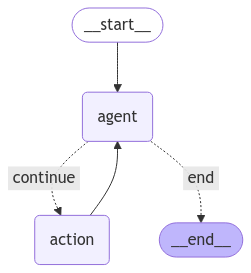

In [6]:
from langgraph.graph import END, StateGraph, START

# Create the workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint
workflow.add_edge(START, "agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

# Complete the loop
workflow.add_edge("action", "agent")

# Compile the graph
app = workflow.compile(debug=True)

app

### Step 7: Visualize the Graph

In [ ]:
app.get_graph().print_ascii()

### Step 8: Invoke the graph

In [8]:
inputs = {"input_text": "what is my mortgage rate for id AVC-1234?"}
final_state = app.invoke(inputs)

print("\nFinal State:")
print(final_state)

[-1:checkpoint] State at the end of step -1:
{'intermediate_steps': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input_text': 'what is my mortgage rate for id AVC-1234?'}
[0:writes] Finished step 0 with writes to 1 channel:
- input_text -> 'what is my mortgage rate for id AVC-1234?'
[0:checkpoint] State at the end of step 0:
{'input_text': 'what is my mortgage rate for id AVC-1234?',
 'intermediate_steps': []}
[1:tasks] Starting 1 task for step 1:
- agent -> {'input_text': 'what is my mortgage rate for id AVC-1234?',
 'intermediate_steps': []}
[1:writes] Finished step 1 with writes to 1 channel:
- output -> [BedrockAgentAction(tool='AssetDetail::getAssetValue', tool_input={'asset_holder_id': 'AVC-1234'}, log='{"returnControl": {"invocationId": "c7087c8c-a340-4c94-854b-7533c707eb11", "invocationInputs": [{"functionInvocationInput": {"actionGroup": "AssetDetail", "actionInvocationType": "RESULT", "agentId": "INLINE_AGENT", "function": "getAssetValue", "parameters": [{"name"

### Step 9: Multiple Conversations with Session Management

In [9]:
# First conversation with a new session
session_id = "test-session-123"

inputs = {
    "input_text": "what is my mortgage rate for id XYZ-789?",
    "session_id": session_id
}

final_state = app.invoke(inputs)
print("\nFirst Conversation:")
print(final_state)

# Second conversation using the same session
inputs = {
    "input_text": "what about for id ABC-456?",
    "session_id": session_id
}

final_state = app.invoke(inputs)
print("\nSecond Conversation:")
print(final_state)

[-1:checkpoint] State at the end of step -1:
{'intermediate_steps': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input_text': 'what is my mortgage rate for id XYZ-789?',
 'session_id': 'test-session-123'}
[0:writes] Finished step 0 with writes to 1 channel:
- input_text -> 'what is my mortgage rate for id XYZ-789?'
[0:checkpoint] State at the end of step 0:
{'input_text': 'what is my mortgage rate for id XYZ-789?',
 'intermediate_steps': []}
[1:tasks] Starting 1 task for step 1:
- agent -> {'input_text': 'what is my mortgage rate for id XYZ-789?',
 'intermediate_steps': []}
[1:writes] Finished step 1 with writes to 1 channel:
- output -> [BedrockAgentAction(tool='AssetDetail::getAssetValue', tool_input={'asset_holder_id': 'XYZ-789'}, log='{"returnControl": {"invocationId": "61d399d4-1d78-4f93-a692-9131047c9ed2", "invocationInputs": [{"functionInvocationInput": {"actionGroup": "AssetDetail", "actionInvocationType": "RESULT", "agentId": "INLINE_AGENT", "function": "getAsset

### Commentary

This notebook demonstrates how to:
1. Use BedrockInlineAgentsRunnable with LangGraph
2. Define and manage state in the graph
3. Handle tool execution and agent responses
4. Maintain session continuity across multiple interactions

Key differences from the regular BedrockAgentsRunnable:
1. No need for agent creation/deletion
2. Configuration provided at runtime
3. More flexible session management
4. No IAM role requirements for agent creation

The graph structure remains the same, but the implementation is more dynamic and suitable for scenarios where agent configuration needs to be flexible or determined at runtime.